In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
from skimage import filters

In [24]:
img_dir = 'RTTS/JPEGImages'

In [25]:
len(os.listdir(img_dir))

4322

### Visual Inspection

In [26]:
def display_img(img_path):
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [27]:
def display_img_grid(img_paths, rows=2, columns=2):
    fig, axs = plt.subplots(rows, columns, figsize=(10,10))

    for ax, img_path in zip(axs.ravel(), img_paths):
        image = Image.open(img_path)
        ax.imshow(image)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    

In [28]:
img_paths = [os.path.join(img_dir, file) for file in os.listdir(img_dir)]

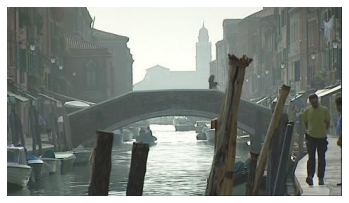

In [29]:
display_img(img_paths[0])

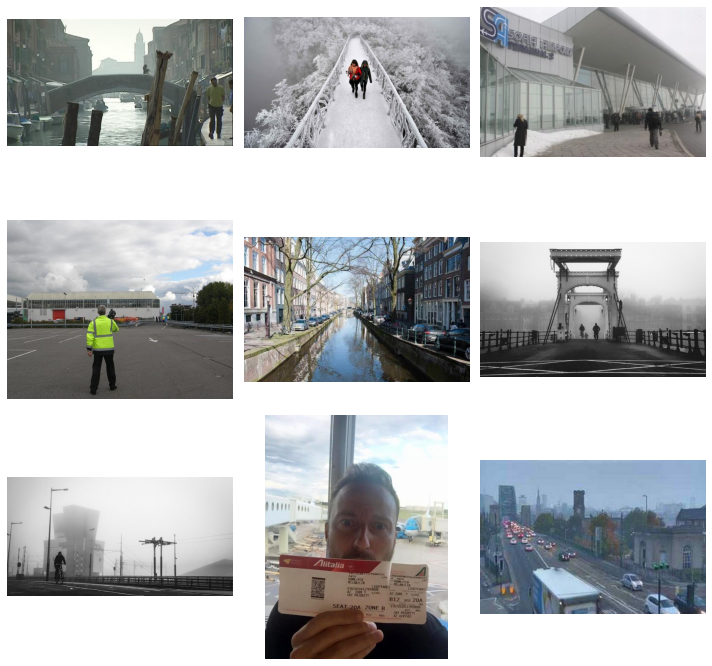

In [30]:
display_img_grid(img_paths, rows=3, columns=3)

### Statistical Analysis

In [31]:
def calculate_brightness(image):
    stat = ImageStat.Stat(image)
    r,g,b = stat.mean
    brightness_value = np.sqrt(0.299 * (r**2) + 0.587 * (g**2) + 0.114 * (b**2))
    return brightness_value

In [32]:
def calculate_contrast(image):
    image_gray = image.convert('L')
    return np.std(image_gray)

In [33]:
def calculate_sharpness(image):
    image_gray = image.convert('L')
    edges = filters.sobel(np.array(image_gray))
    return np.mean(edges)

In [34]:
brightness_values = []
contrast_values = []
sharpness_values = []

for file in os.listdir(img_dir):
    if file.endswith(('.jpg', 'jpeg', '.png')):
        image_path = os.path.join(img_dir, file)
        image = Image.open(image_path)

        brightness = calculate_brightness(image)
        contrast = calculate_contrast(image)
        sharpness = calculate_sharpness(image)
        
        brightness_values.append(brightness)
        contrast_values.append(contrast)
        sharpness_values.append(sharpness)
        

In [35]:
brightness_stats = {'mean': np.mean(brightness_values), 'median': np.median(brightness_values), 'std_dev': np.std(brightness_values)}
contrast_stats = {'mean': np.mean(contrast_values), 'median': np.median(contrast_values), 'std_dev': np.std(contrast_values)}
sharpness_stats = {'mean': np.mean(sharpness_values), 'median': np.median(sharpness_values), 'std_dev': np.std(sharpness_values)}

# Print summary statistics
print("Brightness Stats:", brightness_stats)
print("Contrast Stats:", contrast_stats)
print("Sharpness Stats:", sharpness_stats)

Brightness Stats: {'mean': 140.01287084047465, 'median': 139.08370753552398, 'std_dev': 28.40184190332159}
Contrast Stats: {'mean': 49.30965205271583, 'median': 49.24627691705133, 'std_dev': 17.26886969394426}
Sharpness Stats: {'mean': 0.017893077345293256, 'median': 0.01511452797989704, 'std_dev': 0.011436087442661034}


**Color distribution of the images**

In [38]:
def plot_rgb_histogram(image_path):
    image = Image.open(image_path)
    
    pixels = np.array(image)
    
    red, green, blue = pixels[:,:,0], pixels[:,:,1], pixels[:,:,2]
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle('RGB Color Distribution')
    
    # Plot the histograms
    color_labels = ['Red', 'Green', 'Blue']
    for ax, channel, color in zip(axs, [red, green, blue], color_labels):
        ax.hist(channel.ravel(), bins=256, color=color.lower(), alpha=0.7)
        ax.set_xlim([0, 256])
        ax.set_title(f'{color} Channel')
        ax.set_xlabel('Pixel Intensity')
    
    axs[0].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


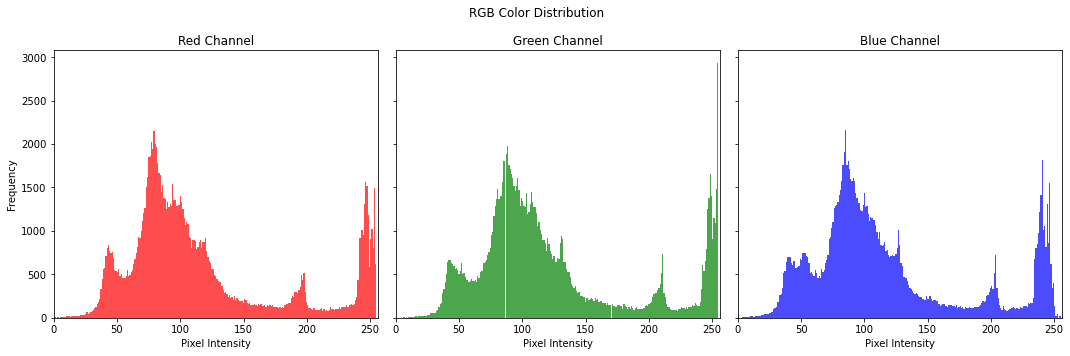

In [39]:
plot_rgb_histogram(img_paths[0])

### Histogram Analysis

In [40]:
def plot_overall_brightness_histogram(image_paths):
    brightness_values = []
    for image_path in image_paths:
        image = Image.open(image_path)
        brightness = calculate_brightness(image)
        brightness_values.append(brightness)
    
    plt.figure(figsize=(10, 6))
    plt.hist(brightness_values, bins=30, color='gray', alpha=0.7)
    plt.title('Overall Brightness Histogram')
    plt.xlabel('Brightness Value')
    plt.ylabel('Frequency')
    plt.show()

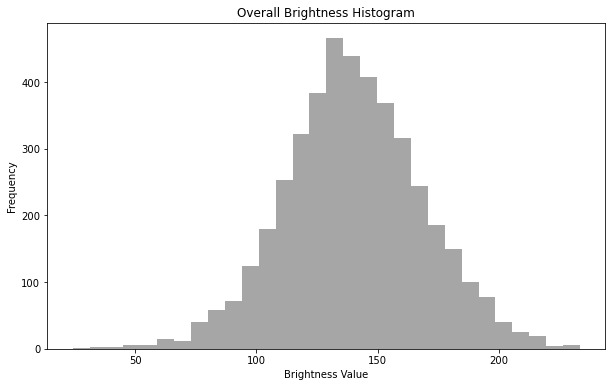

In [41]:
plot_overall_brightness_histogram(img_paths)

### Frequency Domain Analysis

In [42]:
def plot_FFT(image_path):
    image = Image.open(image_path).convert('L')
    image_array = np.array(image)

    #Applying FFT  and shift the zero frequency component to the center
    FFT = np.fft.fftshift(np.fft.fft2(image_array))

    magnitude_spectrum = 20*np.log(np.abs(FFT))

    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_array, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot magnitude spectrum
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum')
    plt.axis('off')
    
    plt.show()


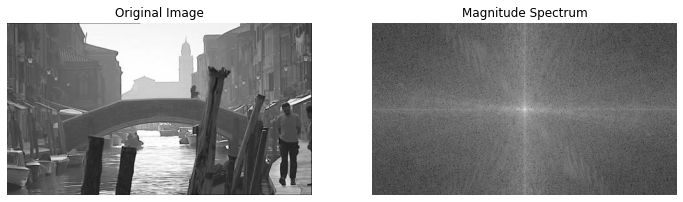

In [46]:
plot_FFT(img_paths[0])

The edges represents high frequencies. In hazy images, one can notice a large number of distributed high frequencies indicating sharp edges and fine details. For hazy images, the magnitude spectrum will have more emphasis on the center (low frequencies), indicating a loss of detail and a prevalence of smoother regions. This visual cue can help quantify the degree of detail loss due to haze and guide subsequent image processing techniques aimed at enhancing or recovering image details

### Texture Aanalysis

In [47]:
from skimage import feature, io, color
from skimage.feature import greycomatrix, greycoprops

In [48]:
def calculate_lbp(image_path):
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)
    # Calculate LBP
    lbp = feature.local_binary_pattern(image_gray, P=8, R=1, method="uniform")
    # Calculate histogram
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

In [49]:
# Function to calculate GLCM features and its properties like contrast, dissimilarity, homogeneity, ASM, energy, and correlation
def calculate_glcm_features(image_path):
    image = io.imread(image_path)
    image_gray = color.rgb2gray(image)
    # Convert to uint8
    image_gray = (image_gray * 255).astype(np.uint8)
    # Calculate GLCM
    glcm = greycomatrix(image_gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    # Calculate GLCM properties
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = greycoprops(glcm, 'homogeneity')[0, 0]
    asm = greycoprops(glcm, 'ASM')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    correlation = greycoprops(glcm, 'correlation')[0, 0]
    
    return contrast, dissimilarity, homogeneity, asm, energy, correlation

In [50]:
# Process images and display texture features
for file in os.listdir(img_dir)[:5]:  # Adjust the slice for the number of images to process
    if file.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(img_dir, file)
        
        # Calculate LBP
        lbp_hist = calculate_lbp(image_path)
        
        # Calculate GLCM features
        glcm_features = calculate_glcm_features(image_path)
        
        # Displaying results
        print(f"Image: {file}")
        print("LBP Histogram:", lbp_hist)
        print("GLCM Features (Contrast, Dissimilarity, Homogeneity, ASM, Energy, Correlation):", glcm_features)
        print("\n")

Image: AM_Bing_211.png
LBP Histogram: [0.0399969  0.09810166 0.03673485 0.08315512 0.15507516 0.14601736
 0.0558345  0.09981404 0.16328839 0.12198202]
GLCM Features (Contrast, Dissimilarity, Homogeneity, ASM, Energy, Correlation): (967.1346723044408, 16.110398559235783, 0.19362718769695858, 0.0006135932654316432, 0.024770814791436377, 0.8772545460484013)


Image: AM_Bing_217.png
LBP Histogram: [0.08676522 0.09397447 0.05250421 0.08470469 0.09254875 0.11081124
 0.0774288  0.09908635 0.13588664 0.16628963]
GLCM Features (Contrast, Dissimilarity, Homogeneity, ASM, Energy, Correlation): (1540.2325648618166, 23.43569162436549, 0.12473358299734989, 0.0001435534718951615, 0.011981380216617845, 0.6337406782664666)


Image: AM_Bing_222.png
LBP Histogram: [0.02839844 0.06731771 0.029375   0.09557943 0.17397786 0.17621745
 0.05529948 0.08240234 0.19440104 0.09703125]
GLCM Features (Contrast, Dissimilarity, Homogeneity, ASM, Energy, Correlation): (598.7799276315787, 13.516848684210522, 0.235339134

 LBP histogram: For hazy images, you might notice a more uniform distribution, indicating less texture variation due to detail blurring.

 GLCM Features: The GLCM features offer insights into texture through various aspects:

    Contrast: Measures the intensity contrast between a pixel and its neighbor over the whole image. Haze might lower contrast.

    Dissimilarity: Similar to contrast but gives less weight to larger differences.

    Homogeneity: Measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal. Higher in hazy images due to reduced texture variance.

    ASM (Angular Second Moment): Provides a measure of homogeneity of the image. Higher values might indicate more uniformity.

    Energy: Square root of ASM, representing texture uniformity. Higher in less textured (possibly hazy) areas.
    
    Correlation: Measures how correlated a pixel is to its neighbor over the entire image. Reduced in hazy conditions due to less distinct texture patterns.

### Haze Index

In [62]:
def calculate_color_shift(image):
    """Calculate the average distance of image colors from pure white."""
    # Convert the image into a NumPy array
    pixels = np.array(image)
    
    # Define the RGB value for pure white
    white = np.array([255, 255, 255])
    
    # Calculate the Euclidean distance from white for each pixel
    distances = np.sqrt(np.sum((pixels - white) ** 2, axis=-1))
    
    # Calculate the average distance
    avg_distance = np.mean(distances)
    
    # Normalize the average distance to a scale of 0 to 1 for consistency with other metrics
    # Assuming the maximum possible distance from white is the distance from white to black (sqrt(3) * 255)
    normalized_avg_distance = avg_distance / (np.sqrt(3) * 255)
    
    # Return the normalized average distance as the color shift metric
    return normalized_avg_distance


In [63]:
def normalize(value, min_value, max_value):
    """Normalize the value to a [0, 1] scale."""
    return (value - min_value) / (max_value - min_value)

def calculate_haze_index(image_path, min_brightness, max_brightness, min_contrast, max_contrast, min_color_shift, max_color_shift, weights={'brightness': 0.33, 'contrast': 0.33, 'color_shift': 0.34}):
    image = Image.open(image_path)
    # Calculate metrics
    brightness = calculate_brightness(image)
    contrast = calculate_contrast(image)
    color_shift = calculate_color_shift(image)
    
    # Normalize metrics
    norm_brightness = normalize(brightness, min_brightness, max_brightness)
    norm_contrast = 1 - normalize(contrast, min_contrast, max_contrast) # Invert because higher contrast means less haze
    norm_color_shift = normalize(color_shift, min_color_shift, max_color_shift)
    
    # Calculate weighted haze index
    haze_index = (weights['brightness'] * norm_brightness +
                  weights['contrast'] * norm_contrast +
                  weights['color_shift'] * norm_color_shift)
    return haze_index


In [64]:
print('max brightness:',max(brightness_values))
print('min brightness:',min(brightness_values))
print('max contrast:',max(contrast_values))
print('min contrast:',min(contrast_values))

max brightness: 233.33651056405563
min brightness: 24.238294535098916
max contrast: 104.02043664020535
min contrast: 7.996409523058226


In [66]:
import csv

min_brightness, max_brightness = 24, 233
min_contrast, max_contrast = 8, 104
min_color_shift, max_color_shift = 0, 1

csv_file_path = 'haze_index.csv'

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Image Name', 'Haze Index'])
    
    # Iterate over images in the dataset folder
    for file in os.listdir(img_dir):
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(img_dir, file)
            
            # Calculate the haze index for the image
            haze_index = calculate_haze_index(image_path, 
                                               min_brightness, max_brightness, 
                                               min_contrast, max_contrast, 
                                               min_color_shift, max_color_shift)
            
            # Write the image name and haze index to the CSV file
            writer.writerow([file, haze_index])